In [2]:
import numpy as np
import tensorflow as tf
from pathlib import Path
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)             
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, split_time_event
from utility.config import load_config
from utility.loss import CoxPHLoss
import paths as pt
from utility.survival import compute_survival_times
from utility.model import load_mlp_model, load_mlp_alea_model, load_vi_model, load_vi_epi_model, load_mcd_model
import math
from utility.survival import coverage, calculate_event_times, compute_survival_function
import torch
from utility.model import load_sota_model
from sksurv.linear_model.coxph import BreslowEstimator

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

RUNS = 100
DATASET_NAME = "WHAS500"
MODEL_VERSION = "FULL"
MODEL_NAMES = ["MLP-ALEA", "VI", "VI-EPI", "MCD"]

# Load config
config = load_config(pt.MLP_CONFIGS_DIR, f"{DATASET_NAME}.yaml")
optimizer = tf.keras.optimizers.deserialize(config['optimizer'])
loss_fn = CoxPHLoss()
activation_fn = config['activiation_fn']
layers = config['network_layers']
dropout_rate = config['dropout_rate']
l2_reg = config['l2_reg']
batch_size = config['batch_size']

# Load data
dl = get_data_loader(DATASET_NAME).load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train, valid and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid  = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Scale data
X_train, X_valid, X_test = scale_data(X_train, X_valid, X_test, cat_features, num_features)
X_train, X_valid, X_test = np.array(X_train), np.array(X_valid), np.array(X_test)

# Make time/event split
t_train, e_train = split_time_event(y_train)
t_test, e_test = split_time_event(y_test)

# Make event times
cox_model = load_sota_model(DATASET_NAME, "Cox")
train_predictions = cox_model.predict(X_train)
breslow = BreslowEstimator().fit(train_predictions, e_train, t_train)
event_times = breslow.unique_times_

# Load models
n_input_dims = X_train.shape[1:]
n_train_samples = X_train.shape[0]
mlp_model = load_mlp_model(DATASET_NAME, n_input_dims)
mlp_alea_model = load_mlp_alea_model(DATASET_NAME, n_input_dims)
vi_model = load_vi_model(DATASET_NAME, n_train_samples, n_input_dims)
vi_epi_model = load_vi_epi_model(DATASET_NAME, n_train_samples, n_input_dims)
mcd_model = load_mcd_model(DATASET_NAME, n_input_dims)

c:\Users\au475271\Miniconda3\envs\py38-baysurv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\au475271\Miniconda3\envs\py38-baysurv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
c:\Users\au475271\Miniconda3\envs\py38-baysurv\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
c:\Users\au475271\Miniconda3\envs\py38-baysurv\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use t

In [3]:
# Test variance on the test set

def measure_model_variance(X_test):
    runs = 100
    models = [mlp_alea_model, vi_model, vi_epi_model, mcd_model]
    model_vars = dict()
    for model, model_name in zip(models, MODEL_NAMES):
        logits_cpd = np.zeros((runs, len(X_test)), dtype=np.float32)
        for i in range(0, runs):
            if model_name in ["MLP-ALEA", "VI", "MCD"]:
                logits_cpd[i,:] = np.reshape(model(X_test, training=False).sample(), len(X_test))
            else:
                logits_cpd[i,:] = np.reshape(model(X_test, training=False), len(X_test))
        mean_std = np.mean(tf.math.reduce_std(logits_cpd, axis=0, keepdims=True))
        model_vars[model_name] = mean_std ** 2
    return model_vars

measure_model_variance(X_test)

{'MLP-ALEA': 0.34868341852530094,
 'VI': 0.6625277052396683,
 'VI-EPI': 0.11247479879429889,
 'MCD': 4.890785718800771}

In [79]:
X_test_one = np.expand_dims(X_test[0], axis=0)

In [107]:
# Train the Brewslow estimator for MLP and make surv funcs
#mlp_alea_surv_times = compute_survival_function(mlp_alea_model, X_train, X_test, e_train, t_train, event_times, RUNS)
#vi_surv_times = compute_survival_function(vi_model, X_train, X_test, e_train, t_train, event_times, RUNS)
#vi_epi_surv_times = compute_survival_function(vi_epi_model, X_train, X_test, e_train, t_train, event_times, RUNS)
n_samples_post = 100
mcd_surv_times = compute_survival_function(mcd_model, X_train, X_test, e_train, t_train, event_times, n_samples_post)
mcd_surv_times_isd = compute_survival_function(mcd_model, X_train, X_test_one, e_train, t_train, event_times, n_samples_post)

In [108]:
# Computer coverage
credible_region_sizes = np.arange(0.1, 1, 0.1)
surv_times = torch.from_numpy(mcd_surv_times)
coverage_stats = {}
for percentage in credible_region_sizes:
    drop_num = math.floor(0.5 * n_samples_post * (1 - percentage))
    lower_outputs = torch.kthvalue(surv_times, k=1 + drop_num, dim=0)[0]
    upper_outputs = torch.kthvalue(surv_times, k=n_samples_post - drop_num, dim=0)[0]
    coverage_stats[percentage] = coverage(event_times, upper_outputs, lower_outputs,
                                          t_test, e_test)
    print("C-cal:", coverage_stats)

C-cal: {0.1: 0.4626865671641791}
C-cal: {0.1: 0.4626865671641791, 0.2: 0.4701492537313433}
C-cal: {0.1: 0.4626865671641791, 0.2: 0.4701492537313433, 0.30000000000000004: 0.48507462686567165}
C-cal: {0.1: 0.4626865671641791, 0.2: 0.4701492537313433, 0.30000000000000004: 0.48507462686567165, 0.4: 0.5}
C-cal: {0.1: 0.4626865671641791, 0.2: 0.4701492537313433, 0.30000000000000004: 0.48507462686567165, 0.4: 0.5, 0.5: 0.5}
C-cal: {0.1: 0.4626865671641791, 0.2: 0.4701492537313433, 0.30000000000000004: 0.48507462686567165, 0.4: 0.5, 0.5: 0.5, 0.6: 0.5149253731343284}
C-cal: {0.1: 0.4626865671641791, 0.2: 0.4701492537313433, 0.30000000000000004: 0.48507462686567165, 0.4: 0.5, 0.5: 0.5, 0.6: 0.5149253731343284, 0.7000000000000001: 0.5447761194029851}
C-cal: {0.1: 0.4626865671641791, 0.2: 0.4701492537313433, 0.30000000000000004: 0.48507462686567165, 0.4: 0.5, 0.5: 0.5, 0.6: 0.5149253731343284, 0.7000000000000001: 0.5447761194029851, 0.8: 0.5447761194029851}
C-cal: {0.1: 0.4626865671641791, 0.2: 0

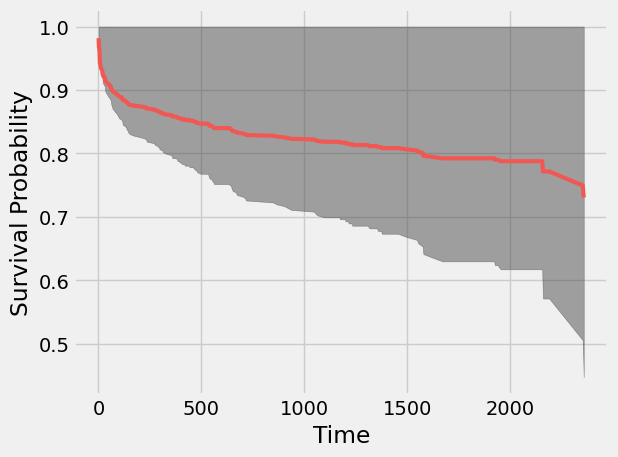

In [109]:
# Compute 90% credible interval
drop_num = math.floor(0.5 * n_samples_post * (1 - 0.9))
mean_outputs = np.mean(mcd_surv_times, axis=0)
lower_outputs = torch.kthvalue(torch.from_numpy(mcd_surv_times), k=1 + drop_num, dim=0)[0]
upper_outputs = torch.kthvalue(torch.from_numpy(mcd_surv_times), k=n_samples_post - drop_num, dim=0)[0]
plt.plot(event_times, np.mean(mean_outputs, axis=0), label="Mean surv", color=TFColor[0], linewidth=3)
plt.fill_between(event_times, upper_outputs[0,:], lower_outputs[0,:], color=TFColor[8], alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.show()

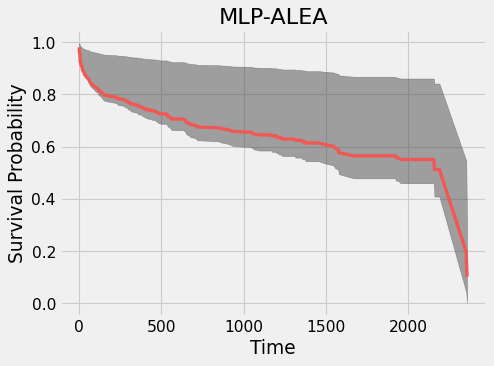

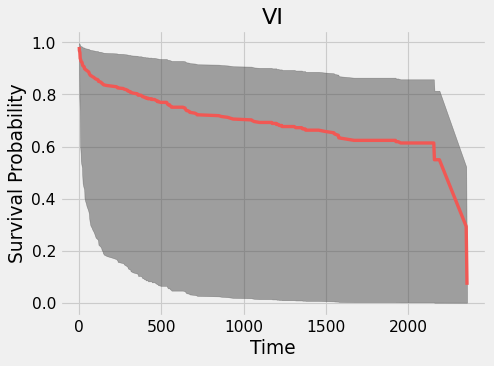

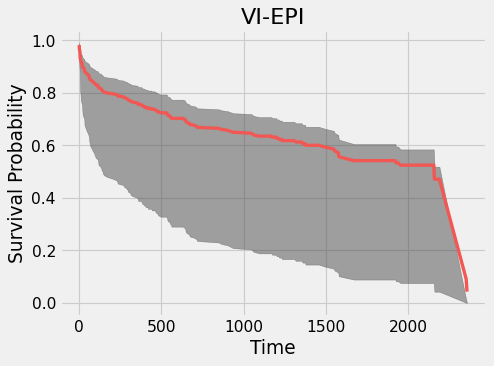

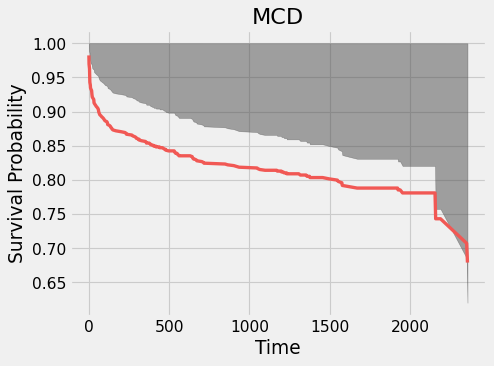

In [27]:
# Plot credible intervals
surv_times = [mlp_alea_surv_times, vi_surv_times, vi_epi_surv_times, mcd_surv_times]
for surv_t, model_name in zip(surv_times, MODEL_NAMES):
    mean_outputs = np.mean(surv_t, axis=0)
    lower_outputs = torch.kthvalue(torch.from_numpy(surv_t), k=1 + drop_num, dim=0)[0]
    upper_outputs = torch.kthvalue(torch.from_numpy(surv_t), k=len(X_test) - drop_num, dim=0)[0]
    plt.figure(dpi=80)
    plt.plot(event_times, np.mean(mean_outputs, axis=0), label="Mean surv", color=TFColor[0], linewidth=3)
    plt.fill_between(event_times, upper_outputs[0,:], lower_outputs[0,:], color=TFColor[8], alpha=0.5)
    plt.title(f"{model_name}")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.tight_layout()
    plt.show()

In [52]:
# Estimate CI and mean survival time
mlp_ci_surv = 1.96 * np.mean(np.std(mlp_breslow_surv_times, axis=1) / np.sqrt(MLP_RUNS), axis=0) # 95% CI
mlp_mean_surv_times = np.mean(np.mean(mlp_breslow_surv_times, axis=1), axis=0)

vi_ci_surv = 1.96 * np.mean(np.std(vi_breslow_surv_times, axis=1) / np.sqrt(VI_RUNS), axis=0) # 95% CI
vi_mean_surv_times = np.mean(np.mean(vi_breslow_surv_times, axis=1), axis=0)

mcd_ci_surv = 1.96 * np.mean(np.std(mcd_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
mcd_mean_surv_times = np.mean(np.mean(mcd_breslow_surv_times, axis=1), axis=0)

# KM
km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['time'].reshape(1,-1),
                                                       y_test['event'].reshape(1,-1),
                                                       event_times)

# Plot surv funcs with mean and CI
plt.figure(dpi=80)
plt.step(event_times, mlp_mean_surv_times, where="post", label="MLP mean (baseline)", color=TFColor[0])
plt.step(event_times, vi_mean_surv_times, where="post", label="VI mean + 95% CI", color=TFColor[2])
plt.step(event_times, mcd_mean_surv_times, where="post", label="MCD mean + 95% CI", color=TFColor[3])
plt.plot(km_mean.columns, km_mean.iloc[0], 'k-', label="Kaplan-Meier + 95% CI", color=TFColor[8])
plt.fill_between(km_mean.columns, km_low.iloc[0], km_high.iloc[0], color="none", edgecolor=TFColor[8], linewidth=2, ls="--")
plt.fill_between(event_times, vi_mean_surv_times-vi_ci_surv, vi_mean_surv_times+vi_ci_surv, color="none", edgecolor=TFColor[2], linewidth=2, ls="--")
plt.fill_between(event_times, mcd_mean_surv_times-mcd_ci_surv, mcd_mean_surv_times+mcd_ci_surv, color="none", edgecolor=TFColor[3], linewidth=2, ls="--")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ [months]")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_all_models.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

NameError: name 'mlp_breslow_surv_times' is not defined

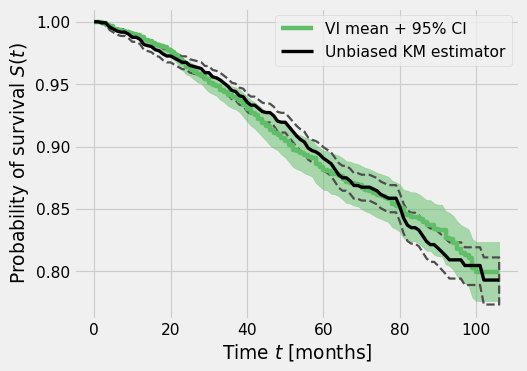

In [ ]:
plt.figure(dpi=80)
plt.step(event_times, vi_mean_surv_times, where="post", label="VI mean + 95% CI", color=TFColor[2])
plt.plot(km_mean.columns, km_mean.iloc[0], 'k-', label='Unbiased KM estimator', linewidth=3)
plt.fill_between(event_times, vi_mean_surv_times-vi_ci_surv, vi_mean_surv_times+vi_ci_surv,
                 color=TFColor[2], alpha=.5)
plt.fill_between(km_mean.columns, km_low.iloc[0], km_high.iloc[0], color="none", edgecolor=TFColor[8], linewidth=2, ls="--")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ [months]")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_vi.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

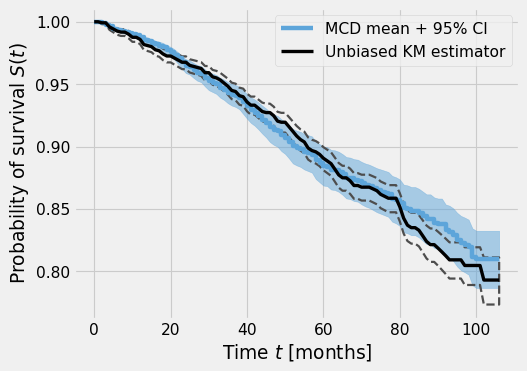

In [ ]:
plt.figure(dpi=80)
plt.step(event_times, mcd_mean_surv_times, where="post", label="MCD mean + 95% CI", color=TFColor[3])
plt.plot(km_mean.columns, km_mean.iloc[0], 'k-', label='Unbiased KM estimator', linewidth=3)
plt.fill_between(event_times, mcd_mean_surv_times-mcd_ci_surv, mcd_mean_surv_times+mcd_ci_surv,
                 color=TFColor[3], alpha=0.5)
plt.fill_between(km_mean.columns, km_low.iloc[0], km_high.iloc[0], color="none", edgecolor=TFColor[8], linewidth=2, ls="--")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ [months]")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_mcd.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
from tools.preprocessor import Preprocessor

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

X_test_g1 = X_test.loc[X_test['Grade'] == "1"]
X_test_g2 = X_test.loc[X_test['Grade'] == "2"]
X_test_g3 = X_test.loc[X_test['Grade'] == "3"]

preprocessor = Preprocessor(cat_feat_strat='mode', num_feat_strat='mean')
transformer = preprocessor.fit(X_train, cat_feats=cat_features, num_feats=num_features,
                                one_hot=True, fill_value=-1)
X_train = np.array(transformer.transform(X_train))
X_test_g1 = np.array(transformer.transform(X_test_g1))
X_test_g2 = np.array(transformer.transform(X_test_g2))
X_test_g3 = np.array(transformer.transform(X_test_g3))

# VI
vi_g1_breslow_surv_times = get_breslow_survival_times(vi_model, X_train, X_test_g1, e_train, t_train, VI_RUNS)
vi_g2_breslow_surv_times = get_breslow_survival_times(vi_model, X_train, X_test_g2, e_train, t_train, VI_RUNS)
vi_g3_breslow_surv_times = get_breslow_survival_times(vi_model, X_train, X_test_g3, e_train, t_train, VI_RUNS)
vi_g1_ci_surv = 1.96 * np.mean(np.std(vi_g1_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
vi_g1_mean_surv_times = np.mean(np.mean(vi_g1_breslow_surv_times, axis=1), axis=0)
vi_g2_ci_surv = 1.96 * np.mean(np.std(vi_g2_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
vi_g2_mean_surv_times = np.mean(np.mean(vi_g2_breslow_surv_times, axis=1), axis=0)
vi_g3_ci_surv = 1.96 * np.mean(np.std(vi_g3_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
vi_g3_mean_surv_times = np.mean(np.mean(vi_g3_breslow_surv_times, axis=1), axis=0)

# MCD
mcd_g1_breslow_surv_times = get_breslow_survival_times(mcd_model, X_train, X_test_g1, e_train, t_train, MCD_RUNS)
mcd_g2_breslow_surv_times = get_breslow_survival_times(mcd_model, X_train, X_test_g2, e_train, t_train, MCD_RUNS)
mcd_g3_breslow_surv_times = get_breslow_survival_times(mcd_model, X_train, X_test_g3, e_train, t_train, MCD_RUNS)
mcd_g1_ci_surv = 1.96 * np.mean(np.std(mcd_g1_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
mcd_g1_mean_surv_times = np.mean(np.mean(mcd_g1_breslow_surv_times, axis=1), axis=0)
mcd_g2_ci_surv = 1.96 * np.mean(np.std(mcd_g2_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
mcd_g2_mean_surv_times = np.mean(np.mean(mcd_g2_breslow_surv_times, axis=1), axis=0)
mcd_g3_ci_surv = 1.96 * np.mean(np.std(mcd_g3_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
mcd_g3_mean_surv_times = np.mean(np.mean(mcd_g3_breslow_surv_times, axis=1), axis=0)

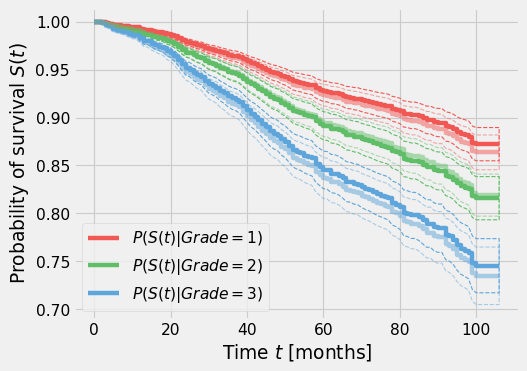

In [ ]:
plt.figure(dpi=80)
plt.step(event_times, vi_g1_mean_surv_times, where="post", label="$S(t|Grade=1)$", color=TFColor[0])
plt.step(event_times, vi_g2_mean_surv_times, where="post", label="$S(t|Grade=2)$", color=TFColor[2])
plt.step(event_times, vi_g3_mean_surv_times, where="post", label="$S(t|Grade=3)$", color=TFColor[3])
plt.step(event_times, mcd_g1_mean_surv_times, where="post", color=TFColor[0], alpha=0.5)
plt.step(event_times, mcd_g2_mean_surv_times, where="post", color=TFColor[2], alpha=0.5)
plt.step(event_times, mcd_g3_mean_surv_times, where="post", color=TFColor[3], alpha=0.5)
plt.fill_between(event_times, vi_g1_mean_surv_times-vi_g1_ci_surv, vi_g1_mean_surv_times+vi_g1_ci_surv, color="none", edgecolor=TFColor[0], linewidth=1, ls="--")
plt.fill_between(event_times, vi_g2_mean_surv_times-vi_g2_ci_surv, vi_g2_mean_surv_times+vi_g2_ci_surv, color="none", edgecolor=TFColor[2], linewidth=1, ls="--")
plt.fill_between(event_times, vi_g3_mean_surv_times-vi_g3_ci_surv, vi_g3_mean_surv_times+vi_g3_ci_surv, color="none", edgecolor=TFColor[3], linewidth=1, ls="--")
plt.fill_between(event_times, mcd_g1_mean_surv_times-mcd_g1_ci_surv, mcd_g1_mean_surv_times+mcd_g1_ci_surv, color="none", edgecolor=TFColor[0], linewidth=1, ls="--", alpha=0.5)
plt.fill_between(event_times, mcd_g2_mean_surv_times-mcd_g2_ci_surv, mcd_g2_mean_surv_times+mcd_g2_ci_surv, color="none", edgecolor=TFColor[2], linewidth=1, ls="--", alpha=0.5)
plt.fill_between(event_times, mcd_g3_mean_surv_times-mcd_g3_ci_surv, mcd_g3_mean_surv_times+mcd_g3_ci_surv, color="none", edgecolor=TFColor[3], linewidth=1, ls="--", alpha=0.5)
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ [months]")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_grade_mcd.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
from tools.model_builder import make_cox_model, make_mlp_model
from utility.survival import compute_survival_times_with_censoring

# Load data
dl = get_data_loader("SEER").load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)

# Make time/event split
t_train, e_train = split_time_event(y_train)
t_test, e_test = split_time_event(y_test)

cox_config = load_config(pt.COX_CONFIGS_DIR, f"SEER.yaml")
cox_model = make_cox_model(cox_config)
cox_model.fit(X_train, y_train)
X_test_sample = X_test.iloc[:5]
cox_preds = cox_model.predict(X_test_sample)
cox_st = compute_survival_times(cox_preds, t_train, e_train)

In [ ]:
mlp_preds = mlp_model.predict(X_test_sample).flatten()
mlp_st = compute_survival_times(mlp_preds, t_train, e_train)
compute_survival_times(mlp_preds, t_train, e_train)

1/1 [==============================] - 0s 82ms/step


array([22.97088825, 18.4349255 , 19.77055977, 34.16256306, 53.33585256])

In [ ]:
n_samples = 1000
model_cpd_st = np.zeros((n_samples, len(X_test_sample)))
for i in range(0, n_samples):
    pred = np.reshape(mcd_model.predict(X_test_sample, verbose=0), len(X_test_sample))
    model_cpd_st[i,:] = compute_survival_times(pred, t_train, e_train)
st_mean = np.mean(model_cpd_st, axis=0)
st_std = np.std(model_cpd_st, axis=0) 

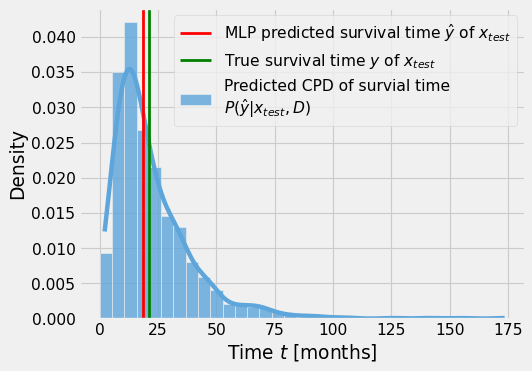

In [ ]:
import seaborn as sns
obs_index = 1
HIST_BINS = np.linspace(0, 100, 20)
plt.figure(dpi=80)
sns.histplot(model_cpd_st[:, obs_index], bins=HIST_BINS, color=TFColor[3],
             label="Predicted CPD of survial time \n$P(\hat{y}|x_{test}, D)$", kde=True, alpha=0.8, stat="density")
plt.axvline(x=mlp_st[obs_index], color='r', linewidth=2.5, label="MLP predicted survival time $\hat{y}$ of $x_{test}$") # TODO: Use y
plt.axvline(x=y_test['time'][obs_index], color='g', linewidth=2.5, label="True survival time $y$ of $x_{test}$") # TODO: Use y
plt.xlabel("Time $t$ [months]")
plt.legend()
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_pred_cpd_mcd.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()